In [1]:
# %%capture cap
!pip install -q ipywidgets
!pip install -q autogluon scikit-learn==1.5.2 
!apt-get install -q -y graphviz graphviz-dev && pip install -q pydot
!pip install -q pygraphviz

## To use Foundtion models: data ~100k rows --
# !pip install autogluon.tabular[tabarena]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 14.6 MB/s eta 0:00:

In [2]:
import torch
import os
import pydot

import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import time, sleep
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 500)
# plt.style.use("ggplot")
sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

print("Packages import succesful!")

Packages import succesful!


In [3]:
## -- Load Data --
PATH = '/kaggle/input/competitions/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

ORIG_PATH = '/kaggle/input/datasets/sylvesterdalmeida/myheart-disease-dataset/'
# ORIG_PATH = '/kaggle/input/datasets/neurocipher/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

TARGET = train.columns[-1]
CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

# for df in [train, orig]:
#     df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [4]:
display(orig.head())
orig.info()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [5]:
MODELS_PATH = "/kaggle/working/AG_models/"
# !rm -r {MODELS_PATH}

In [6]:
from autogluon.tabular import TabularPredictor

In [7]:
## -- Original_Predict_Train_Test_data
TIME_1_HR = 3600
predictor = TabularPredictor(
                label = TARGET,
         # problem_type = "regression",
          eval_metric = 'roc_auc',
                 path = MODELS_PATH,
    ).fit(
                   train_data = orig,
                      presets = 'best',
                num_bag_folds = orig.shape[0] // 10,
                   # auto_stack = False,
             dynamic_stacking = False,
             num_stack_levels = 1,
                   time_limit = TIME_1_HR,
                 # num_bag_sets = 2,
                  # ag_args_fit = {'num_cpus': os.cpu_count()},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Jan 17 11:20:45 UTC 2026
CPU Count:          4
Memory Avail:       29.93 GB / 31.35 GB (95.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=27, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/kaggle/working/AG_models"
Train Data Rows:    270
Train Data Columns: 13
Label Column:       Heart Disease
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['Presence', 'Absence']
	If 'binary' is not the correct problem_type, please manuall

In [8]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}\n") 

## -- RUN 1 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 51
-> Best model   : WeightedEnsemble_L3



,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.983333,roc_auc,3.727847,867.814058,0.000862,0.060008,3,True,51
1,LightGBM_r131_BAG_L2,0.977944,roc_auc,1.916208,404.722858,0.175304,64.596920,2,True,47
2,LightGBM_BAG_L2,0.977222,roc_auc,1.853789,398.414501,0.112886,58.288564,2,True,35
3,CatBoost_BAG_L2,0.977222,roc_auc,1.892144,587.454213,0.151241,247.328275,2,True,38
4,XGBoost_BAG_L2,0.974944,roc_auc,2.011166,373.776870,0.270262,33.650933,2,True,42
5,CatBoost_r177_BAG_L2,0.974500,roc_auc,1.890818,442.508735,0.149915,102.382798,2,True,45
6,CatBoost_r9_BAG_L2,0.973500,roc_auc,1.896318,473.347498,0.155415,133.221560,2,True,49
7,NeuralNetFastAI_r191_BAG_L2,0.967944,roc_auc,2.268282,430.179110,0.527379,90.053172,2,True,48
8,LightGBM_r96_BAG_L2,0.966583,roc_auc,1.894884,402.298973,0.153981,62.173035,2,True,50
9,LightGBMLarge_BAG_L2,0.966528,roc_auc,1.881423,403.808510,0.140520,63.682572,2,True,44


In [9]:
# ## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
# )

In [10]:
# ## -- Get Summary -- 
# print(f"-> Total models : {len(predictor.model_names())}")
# print(f"-> Best model   : {predictor.model_best}\n") 

# ## -- RUN 2 RESULTS -- 
# leaderboard = predictor.leaderboard(silent=True)
# leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

In [11]:
## -- Create folder directory to save predictions --
SAVE_PATH = '/kaggle/working/AG_preds/'
FILE_NAME = 'ag_heart_disease_orig.parquet'
!mkdir {SAVE_PATH}

print(f"Path created: {SAVE_PATH}")

Path created: /kaggle/working/AG_preds/


In [12]:
%%time

## -- OOF PREDICTIONS --
oof_name = f'{SAVE_PATH}oof_{FILE_NAME}'
final_oof = pd.DataFrame()

ag_oof_preds = predictor.predict_proba_multi(as_pandas=False, as_multiclass=False)
for k, v in tqdm(ag_oof_preds.items(), desc='Exporting OOF predictions'):
    k_renamed = k.replace('_', '') 
    final_oof[k_renamed] = v.ravel()

final_oof.to_parquet(oof_name, index=False)
print(f"OOF PREDICTIONS SAVED: {oof_name}. Shape: {final_oof.shape}\n")

final_oof.head()

Exporting OOF predictions:   0%|          | 0/51 [00:00<?, ?it/s]

OOF PREDICTIONS SAVED: /kaggle/working/AG_preds/oof_ag_heart_disease_orig.parquet. Shape: (270, 51)

CPU times: user 76.4 ms, sys: 18.4 ms, total: 94.9 ms
Wall time: 118 ms


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,NeuralNetTorchBAGL1,LightGBMLargeBAGL1,CatBoostr177BAGL1,NeuralNetTorchr79BAGL1,LightGBMr131BAGL1,NeuralNetFastAIr191BAGL1,CatBoostr9BAGL1,LightGBMr96BAGL1,NeuralNetTorchr22BAGL1,XGBoostr33BAGL1,ExtraTreesr42BAGL1,CatBoostr137BAGL1,NeuralNetFastAIr102BAGL1,CatBoostr13BAGL1,RandomForestr195BAGL1,LightGBMr188BAGL1,NeuralNetFastAIr145BAGL1,XGBoostr89BAGL1,NeuralNetTorchr30BAGL1,LightGBMr130BAGL1,NeuralNetTorchr86BAGL1,CatBoostr50BAGL1,NeuralNetFastAIr11BAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,NeuralNetTorchBAGL2,LightGBMLargeBAGL2,CatBoostr177BAGL2,NeuralNetTorchr79BAGL2,LightGBMr131BAGL2,NeuralNetFastAIr191BAGL2,CatBoostr9BAGL2,LightGBMr96BAGL2,WeightedEnsembleL3
0,0.955092,0.944264,0.742574,0.792079,0.885084,0.722772,0.732673,0.902467,0.932249,0.975607,0.897262,0.957503,0.925642,0.922538,0.942870,0.905488,0.945161,0.835669,0.929281,0.801980,0.937086,0.999966,0.911581,0.742574,0.943586,0.966621,0.937530,0.966220,0.921090,0.988925,0.898833,0.999997,0.971735,1.000000,1.000000,0.990099,0.990099,0.999846,1.000000,0.980198,0.997834,0.972250,0.957835,0.999998,0.999852,0.966454,1.000000,0.999987,0.998713,0.996859,0.989593
1,0.381035,0.167709,0.508333,0.483333,0.399710,0.441667,0.541667,0.710916,0.192638,0.490870,0.154748,0.380083,0.099328,0.219025,0.759997,0.432917,0.450609,0.580728,0.264839,0.575000,0.401126,0.383096,0.441723,0.566667,0.308244,0.593937,0.236433,0.881172,0.310038,0.225480,0.517226,0.089745,0.179852,0.239759,0.013751,0.258333,0.333333,0.154626,0.400000,0.425000,0.374834,0.318253,0.257536,0.243470,0.136900,0.018936,0.017455,0.008312,0.167546,0.339739,0.105561
2,0.178931,0.335776,0.154545,0.172727,0.120865,0.145455,0.200000,0.229434,0.234476,0.159999,0.096163,0.230309,0.006780,0.232815,0.282392,0.135112,0.167935,0.011832,0.146801,0.100000,0.194144,0.245617,0.190982,0.172727,0.185853,0.278221,0.156705,0.022100,0.145112,0.051474,0.168624,0.497072,0.370924,0.261691,0.410458,0.236364,0.200000,0.902492,0.281818,0.263636,0.518805,0.290670,0.102781,0.610606,0.671819,0.563574,0.268501,0.744839,0.655711,0.144530,0.584568
3,0.739031,0.739939,0.908257,0.917431,0.839535,0.944954,0.926606,0.839063,0.618633,0.576010,0.671158,0.771109,0.880287,0.683184,0.767379,0.754512,0.822693,0.994149,0.648751,0.963303,0.783665,0.802427,0.792113,0.871560,0.739127,0.810871,0.531008,0.997217,0.793286,0.999770,0.807938,0.943829,0.823637,0.871526,0.930699,0.825688,0.807339,0.929079,0.880734,0.834862,0.726989,0.851969,0.955536,0.774748,0.873363,0.345607,0.892702,0.232355,0.841741,0.866951,0.731910
4,0.220903,0.049005,0.330357,0.312500,0.127074,0.276786,0.294643,0.093604,0.059991,0.240012,0.149426,0.061762,0.004469,0.049111,0.002095,0.048088,0.225244,0.179072,0.049986,0.232143,0.116090,0.009769,0.183304,0.232143,0.021572,0.006980,0.031512,0.026044,0.144394,0.069037,0.085199,0.001496,0.019463,0.080907,0.008540,0.044643,0.062500,0.026505,0.080357,0.107143,0.005191,0.060883,0.119782,0.110892,0.040939,0.005525,0.082807,0.000430,0.053216,0.096273,0.038342


In [13]:
%%time

## -- TRAIN PREDICTIONS --
train_name = f'{SAVE_PATH}train_{FILE_NAME}'
final_train = pd.DataFrame()

ag_train_preds = predictor.predict_proba_multi(train[BASE], as_pandas=False, as_multiclass=False)
for k, v in tqdm(ag_train_preds.items(), desc='Exporting TRAIN predictions'):
    k_renamed = k.replace('_', '') 
    final_train[k_renamed] = v.ravel()

final_train.to_parquet(train_name, index=False)
print(f"TRAIN PREDICTIONS SAVED: {train_name}\n")

final_train.head()

Exporting TRAIN predictions:   0%|          | 0/51 [00:00<?, ?it/s]

TRAIN PREDICTIONS SAVED: /kaggle/working/AG_preds/train_ag_heart_disease_orig.parquet

CPU times: user 7h 47min 35s, sys: 1min 56s, total: 7h 49min 32s
Wall time: 3h 50min 44s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,NeuralNetTorchBAGL1,LightGBMLargeBAGL1,CatBoostr177BAGL1,NeuralNetTorchr79BAGL1,LightGBMr131BAGL1,NeuralNetFastAIr191BAGL1,CatBoostr9BAGL1,LightGBMr96BAGL1,NeuralNetTorchr22BAGL1,XGBoostr33BAGL1,ExtraTreesr42BAGL1,CatBoostr137BAGL1,NeuralNetFastAIr102BAGL1,CatBoostr13BAGL1,RandomForestr195BAGL1,LightGBMr188BAGL1,NeuralNetFastAIr145BAGL1,XGBoostr89BAGL1,NeuralNetTorchr30BAGL1,LightGBMr130BAGL1,NeuralNetTorchr86BAGL1,CatBoostr50BAGL1,NeuralNetFastAIr11BAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,NeuralNetTorchBAGL2,LightGBMLargeBAGL2,CatBoostr177BAGL2,NeuralNetTorchr79BAGL2,LightGBMr131BAGL2,NeuralNetFastAIr191BAGL2,CatBoostr9BAGL2,LightGBMr96BAGL2,WeightedEnsembleL3
0,0.959546,0.949868,0.936667,0.963333,0.936160,0.966667,0.970000,0.949002,0.952349,0.904641,0.855048,0.925993,0.989868,0.937717,0.967151,0.939229,0.943414,0.987281,0.946944,0.986667,0.945654,0.987198,0.925145,0.976667,0.942908,0.970787,0.951375,0.997763,0.965929,0.964552,0.949105,0.998299,0.980419,0.963498,0.966052,0.990000,0.996667,0.968571,0.996667,0.990000,0.972193,0.969848,0.948595,0.946920,0.965442,0.995917,0.965179,0.978571,0.969986,0.948142,0.974107
1,0.117969,0.074017,0.066667,0.073333,0.091724,0.140000,0.133333,0.148865,0.092066,0.091342,0.117146,0.093459,0.225916,0.085677,0.133928,0.089146,0.122445,0.122082,0.075145,0.153333,0.116467,0.128815,0.074977,0.090000,0.136156,0.178982,0.070818,0.212376,0.060854,0.109172,0.115481,0.171145,0.139105,0.092348,0.076942,0.103333,0.086667,0.096122,0.096667,0.153333,0.084111,0.158664,0.110020,0.069599,0.092341,0.039477,0.071849,0.082973,0.085953,0.102505,0.087235
2,0.046038,0.056072,0.170000,0.106667,0.076771,0.116667,0.150000,0.085880,0.079244,0.066924,0.161490,0.089041,0.008837,0.068220,0.061147,0.078638,0.052631,0.042099,0.101197,0.116667,0.083013,0.025829,0.076492,0.173333,0.078624,0.108816,0.115307,0.002290,0.036275,0.040059,0.098307,0.027961,0.058591,0.031179,0.025317,0.036667,0.040000,0.033920,0.040000,0.046667,0.056865,0.024476,0.070987,0.042552,0.037866,0.010841,0.028195,0.048661,0.031413,0.042514,0.028216
3,0.046467,0.048308,0.053333,0.036667,0.069626,0.026667,0.010000,0.089014,0.044516,0.115594,0.114014,0.089005,0.014987,0.053648,0.100603,0.049018,0.084927,0.068966,0.048210,0.006667,0.075574,0.037292,0.054844,0.023333,0.044407,0.095895,0.046604,0.005433,0.067752,0.063343,0.072563,0.038448,0.044752,0.028035,0.025742,0.036667,0.010000,0.030966,0.003333,0.000000,0.066814,0.023804,0.060970,0.042485,0.032158,0.007878,0.027588,0.062017,0.026948,0.042583,0.027698
4,0.936272,0.932502,0.953333,0.936667,0.924011,0.950000,0.953333,0.966641,0.939797,0.930439,0.848328,0.918785,0.991581,0.927500,0.967937,0.928259,0.903765,0.984986,0.928213,0.980000,0.928178,0.974845,0.918400,0.970000,0.938179,0.975590,0.936242,0.998714,0.943591,0.975948,0.939424,0.998570,0.975595,0.971290,0.966351,0.996667,0.993333,0.970262,1.000000,0.993333,0.975509,0.968386,0.954589,0.946923,0.966610,0.996097,0.964462,0.984570,0.969184,0.952107,0.974897


In [14]:
%%time

## -- TEST PREDICTIONS --
test_name = f"{SAVE_PATH}test_{FILE_NAME}"
final_test = pd.DataFrame()

ag_test_preds = predictor.predict_proba_multi(test[BASE], as_pandas=False, as_multiclass=False)
for k, v in tqdm(ag_test_preds.items(), desc='Exporting TEST predictions'):
    k_renamed = k.replace('_', '')
    final_test[k_renamed] = v.ravel()

final_test.to_parquet(test_name, index=False)
print(f"TEST PREDICTIONS SAVED: {test_name}\n")

final_test.head()

Exporting TEST predictions:   0%|          | 0/51 [00:00<?, ?it/s]

TEST PREDICTIONS SAVED: /kaggle/working/AG_preds/test_ag_heart_disease_orig.parquet

CPU times: user 3h 26min 37s, sys: 43.3 s, total: 3h 27min 20s
Wall time: 1h 42min 2s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,NeuralNetTorchBAGL1,LightGBMLargeBAGL1,CatBoostr177BAGL1,NeuralNetTorchr79BAGL1,LightGBMr131BAGL1,NeuralNetFastAIr191BAGL1,CatBoostr9BAGL1,LightGBMr96BAGL1,NeuralNetTorchr22BAGL1,XGBoostr33BAGL1,ExtraTreesr42BAGL1,CatBoostr137BAGL1,NeuralNetFastAIr102BAGL1,CatBoostr13BAGL1,RandomForestr195BAGL1,LightGBMr188BAGL1,NeuralNetFastAIr145BAGL1,XGBoostr89BAGL1,NeuralNetTorchr30BAGL1,LightGBMr130BAGL1,NeuralNetTorchr86BAGL1,CatBoostr50BAGL1,NeuralNetFastAIr11BAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,NeuralNetTorchBAGL2,LightGBMLargeBAGL2,CatBoostr177BAGL2,NeuralNetTorchr79BAGL2,LightGBMr131BAGL2,NeuralNetFastAIr191BAGL2,CatBoostr9BAGL2,LightGBMr96BAGL2,WeightedEnsembleL3
0,0.913238,0.757188,0.650000,0.696667,0.751002,0.743333,0.696667,0.902592,0.659414,0.871282,0.748274,0.700888,0.955906,0.752212,0.920457,0.777289,0.876209,0.911802,0.766240,0.636667,0.733577,0.903704,0.701783,0.606667,0.923090,0.942261,0.822197,0.986027,0.746032,0.950998,0.788833,0.965118,0.907352,0.955366,0.963304,0.940000,0.920000,0.958536,0.913333,0.933333,0.958409,0.963949,0.928426,0.944143,0.954765,0.992724,0.956142,0.969889,0.961380,0.933461,0.966333
1,0.026084,0.029196,0.003333,0.003333,0.050086,0.000000,0.006667,0.039180,0.038003,0.045684,0.110603,0.057330,0.005712,0.035603,0.037147,0.034747,0.033554,0.016148,0.037490,0.000000,0.051272,0.013129,0.036666,0.000000,0.035256,0.049916,0.035935,0.000643,0.018813,0.017667,0.052979,0.004698,0.018542,0.023408,0.024879,0.000000,0.000000,0.023588,0.000000,0.000000,0.042540,0.023748,0.046271,0.042407,0.027199,0.002055,0.027001,0.035773,0.024255,0.037877,0.021482
2,0.856221,0.758033,0.836667,0.796667,0.840924,0.843333,0.840000,0.918805,0.838693,0.871043,0.786868,0.829056,0.961701,0.760369,0.934008,0.798549,0.878725,0.902342,0.878990,0.796667,0.837218,0.959452,0.838099,0.803333,0.822372,0.938313,0.863280,0.988815,0.899518,0.946959,0.794578,0.983759,0.929992,0.931907,0.965825,0.923333,0.930000,0.961134,0.906667,0.900000,0.947554,0.963340,0.931308,0.945740,0.959260,0.993629,0.960633,0.965858,0.958715,0.905766,0.967969
3,0.028225,0.032955,0.030000,0.003333,0.054103,0.013333,0.006667,0.043624,0.043260,0.072230,0.110040,0.062356,0.005734,0.042977,0.048188,0.038995,0.040418,0.017171,0.042081,0.003333,0.054410,0.017312,0.041567,0.006667,0.035269,0.066887,0.038666,0.000435,0.021457,0.027592,0.053518,0.005246,0.019635,0.023221,0.024978,0.003333,0.003333,0.025097,0.000000,0.000000,0.042851,0.023826,0.052430,0.042398,0.029145,0.000908,0.027952,0.038621,0.024456,0.036927,0.022276
4,0.358211,0.274382,0.383333,0.343333,0.355237,0.423333,0.403333,0.497166,0.223638,0.413733,0.209127,0.353305,0.543122,0.222640,0.534145,0.300603,0.496056,0.363790,0.235053,0.376667,0.376434,0.475274,0.311147,0.330000,0.313153,0.536571,0.255684,0.485834,0.534806,0.520765,0.362401,0.402640,0.360871,0.638947,0.523387,0.386667,0.410000,0.498702,0.393333,0.423333,0.652743,0.438768,0.598758,0.273071,0.453987,0.763942,0.345705,0.600460,0.593551,0.648289,0.513925


In [15]:
final_train.shape, final_test.shape, final_oof.shape

((630000, 51), (270000, 51), (270, 51))

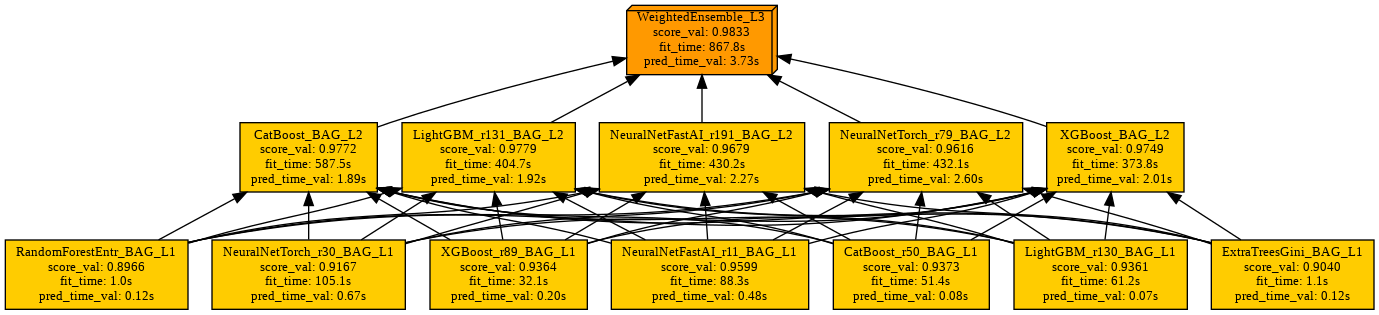

In [16]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image(f'{MODELS_PATH}ensemble_model.png'))

In [17]:
# import xgboost

# orig[TARGET] = orig[TARGET].map({'Presence': 1, 'Absence': 0})

# model = xgboost.XGBClassifier(random_state=42)
# model.fit(orig[BASE], orig[TARGET])

# display(model)

# train_preds = model.predict_proba(train[BASE].iloc[:100])[:, 1]
# test_preds = model.predict_proba(test[BASE].iloc[:100])[:, 1]

# pd.Series(train_preds).head(), pd.Series(test_preds).head()

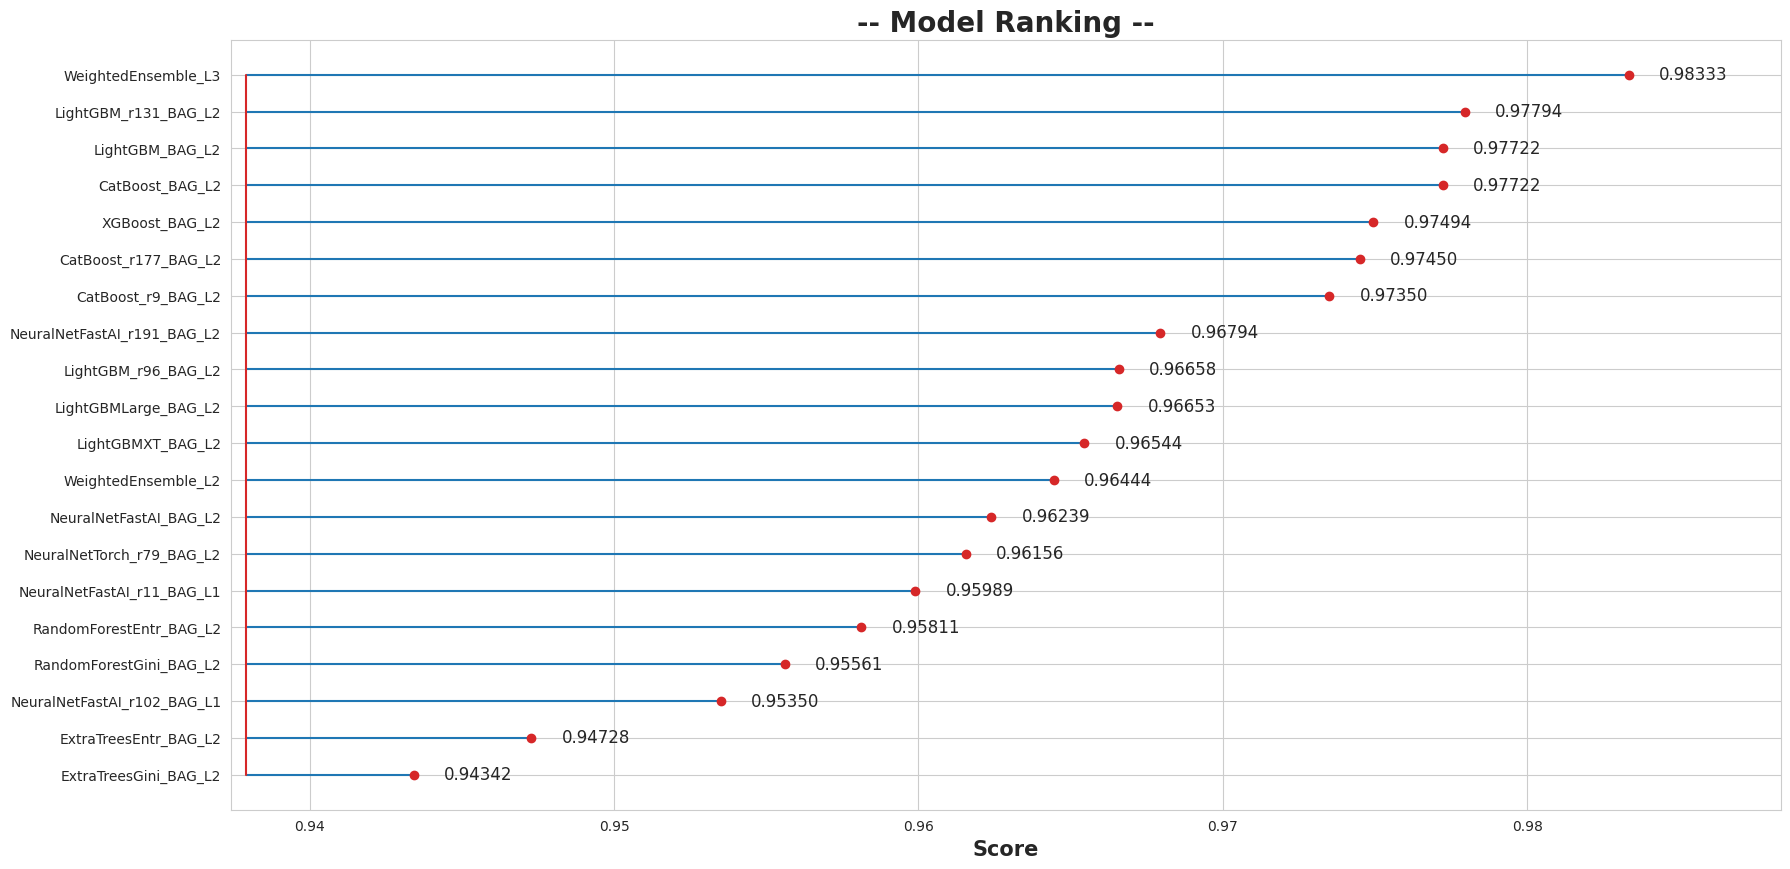

In [18]:
## -- Extract model scores --
# result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(dict(zip(leaderboard['model'], leaderboard['score_val'])), orient='index')\
              .rename(columns={0: 'scores'}).iloc[:20] \
              .sort_values(by='scores')

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(20, 10))
plt.stem(
    result_df.index,
    result_df['scores'],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.005)
plt.xlabel('Score', fontdict={'size': 15, 'weight': 'semibold'})
plt.title('-- Model Ranking --', fontdict={'size': 20, 'weight': 'semibold'})

for i, value in enumerate(result_df['scores']):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontsize=12)

# plt.grid(True, axis='x')
# plt.tight_layout()
plt.show()

# ~ HILLCLIMB

In [19]:
%%time

try:
    from hillclimbers import climb_hill, partial
except:
    !pip install -q -U hillclimbers
    from hillclimbers import climb_hill, partial

from sklearn.metrics import roc_auc_score

## -- RUN CLIMBER --
L1_COLS = [c for c in final_train.columns if 'L1' in c]

for name, df in [('train', final_train), ('test', final_test)]:
    print(f"========== STARTING HILLCLIMB FOR {name.upper()} DATA ===========")
    hc_test, hc_oof = climb_hill(
            train= orig,
            target= TARGET,
            oof_pred_df= final_oof[L1_COLS],
            test_pred_df= df[L1_COLS],
            eval_metric= partial(roc_auc_score),
            objective= 'maximize',
            # negative_weights=True,
            return_oof_preds= True,
            precision= 0.001,
            plot_hill= True,
            plot_hist= False,
    )
    
    np.save(f"{SAVE_PATH}ag_oof_{name.upper()}_HC_FINAL.npy", hc_oof)
    np.save(f"{SAVE_PATH}ag_test_{name.upper()}_HC_FINAL.npy", hc_test)
    
    print(f"✅ {name}: HILLCLIMB FILES SAVED!")
    print()

  Preparing metadata (setup.py) ... done
========== STARTING HILLCLIMB FOR TRAIN DATA ===========
   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (32 total): 

NeuralNetFastAIr11BAGL1:  0.95989 (best solo model)
NeuralNetFastAIr102BAGL1: 0.95350
NeuralNetFastAIr191BAGL1: 0.93889
CatBoostr50BAGL1:         0.93728
XGBoostr89BAGL1:          0.93644
LightGBMr130BAGL1:        0.93606
CatBoostr137BAGL1:        0.93544
CatBoostr177BAGL1:        0.93483
LightGBMBAGL1:            0.93383
NeuralNetFastAIr145BAGL1: 0.93317
CatBoostBAGL1:            0.93222
LightGBMr131BAGL1:        0.93139
LightGBMr188BAGL1:        0.92922
XGBoostr33BAGL1:          0.92889
XGBoostBAGL1:             0.92800
CatBoostr9BAGL1:          0.92800
LightGBMXTBAGL1:          0.92600
LightGBMr96BAGL1:         0.92461
CatBoostr13BAGL1:         0.92428
NeuralNetFastAIBAGL1:     0.92411
NeuralNetTorchr30BAGL1:   0.91672
NeuralNetTorchr22BAGL1:   0.91250
NeuralNetTorchr79BAGL1:   0.91239
LightGBMLargeB

✅ train: HILLCLIMB FILES SAVED!

========== STARTING HILLCLIMB FOR TEST DATA ===========
   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (32 total): 

NeuralNetFastAIr11BAGL1:  0.95989 (best solo model)
NeuralNetFastAIr102BAGL1: 0.95350
NeuralNetFastAIr191BAGL1: 0.93889
CatBoostr50BAGL1:         0.93728
XGBoostr89BAGL1:          0.93644
LightGBMr130BAGL1:        0.93606
CatBoostr137BAGL1:        0.93544
CatBoostr177BAGL1:        0.93483
LightGBMBAGL1:            0.93383
NeuralNetFastAIr145BAGL1: 0.93317
CatBoostBAGL1:            0.93222
LightGBMr131BAGL1:        0.93139
LightGBMr188BAGL1:        0.92922
XGBoostr33BAGL1:          0.92889
XGBoostBAGL1:             0.92800
CatBoostr9BAGL1:          0.92800
LightGBMXTBAGL1:          0.92600
LightGBMr96BAGL1:         0.92461
CatBoostr13BAGL1:         0.92428
NeuralNetFastAIBAGL1:     0.92411
NeuralNetTorchr30BAGL1:   0.91672
NeuralNetTorchr22BAGL1:   0.91250
NeuralNetTorchr79BAGL1:   0.91239
LightGBMLargeBAGL1:    

✅ test: HILLCLIMB FILES SAVED!

CPU times: user 8min 10s, sys: 1.41 s, total: 8min 12s
Wall time: 8min 19s


In [20]:
print(f"""
{'-'*47}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE - | {'█'*5}
{'-'*47}
""")


-----------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE - | █████
-----------------------------------------------



In [21]:
## -- OPTIONAL: Delete stored files --
!rm -r {MODELS_PATH}